In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
os.chdir('/content/drive/MyDrive/Master Thesis/src')
from mnist_utils import load_and_transform_mnist, transform_labels_to_binary
from trainers import *
from plots import *

In [4]:
os.chdir('/content/drive/MyDrive/Master Thesis')

MNIST_PATH = '/content/drive/MyDrive/datasets'
RESULTS_PATH = os.path.join(os.path.join(os.getcwd(), "results"), "layers=2 relu classes=[6,8]")

In [5]:
new_dim = 10
keep_classes = [6,8]

criterion = nn.BCELoss()

def get_net():
    return nn.Sequential(
        nn.Linear(new_dim,5),
        nn.ReLU(),
        nn.Linear(5,1),
        nn.Sigmoid()
    )

def get_dataset():
    dataset = load_and_transform_mnist(MNIST_PATH, new_dim, keep_classes)
    # the following needed specifically for BCELoss
    dataset["train_targets"] = dataset["train_targets"][..., None].float()
    dataset["test_targets"] = dataset["test_targets"][..., None].float()
    return dataset

In [6]:
def print_negative_psdness(trainer_):
    iters, psd_ness = get_psd_ness(trainer_)
    for i, psd in zip(iters, psd_ness):
        if psd < 0:
            iter_id = trainer_.metrics["iter"].index(i)
            hess_iter_id = trainer_.hessian_metrics["iter"].index(i-1) # cause we computer lambda_n after previous step
            lambda_n = trainer_.hessian_metrics["lambda_n"][hess_iter_id]
            M = trainer_.metrics["M"][iter_id]
            r = trainer_.metrics["step_size"][iter_id]
            print(f"iter = {iter_id}: lambda_n = {lambda_n}, M = {M}, r = {r}, lambda_n + M*r/2 = {psd}")

# Cubic Newton

In [7]:
CN_trainer = {}

for M_min, max_iters in zip([1e-4, 1e-2, 1e-1], [35, 35, 40]):
    seed = 0
    print_every = 5
    eval_every = 1
    eval_hessian_every = 1
    save_spectrum_every = 5
    save_hessian_every = 10
    save_every = 35
    weight_decay = 0.
    # kwargs
    M = 1.0

    model_dir = os.path.join(os.path.join(RESULTS_PATH, "CN"), f"seed={seed} M_min={M_min}")
    print(f"model_dir: {model_dir}")

    torch.manual_seed(seed)
    CN_trainer[M_min] = AdaptiveCubicNewtonTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, M,  M_min)
    CN_trainer[M_min].load()
    print_training_stats(CN_trainer[M_min], print_every)
    #_ = CN_trainer[M_min].train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/layers=2 relu classes=[6,8]/CN/seed=0 M_min=0.0001
     0: train loss =  0.706261, test loss =  0.704212, M =   1.00000000, time =    0.00 sec, lambda_n = -1.491387
     5: train loss =  0.113494, test loss =  0.114291, M =   2.00000000, time =    0.45 sec, lambda_n = -0.070204
    10: train loss =  0.039521, test loss =  0.038772, M =   0.06250000, time =    0.88 sec, lambda_n = -0.005006
    15: train loss =  0.025273, test loss =  0.026438, M =   0.03125000, time =    1.35 sec, lambda_n = -0.000618
    20: train loss =  0.021524, test loss =  0.025219, M =   4.00000000, time =    1.82 sec, lambda_n = -0.000117
    25: train loss =  0.021443, test loss =  0.025157, M = 16384.00000000, time =    2.34 sec, lambda_n = -0.000103
    30: train loss =  0.021443, test loss =  0.025157, M = 35184372088832.00000000, time =    2.93 sec, lambda_n = -0.000098
    35: train loss =  0.021443, test loss =  0.025157, M = 35184372088832.00000000

In [ ]:
print_test_accuracy(CN_trainer[1e-4])

Best test accuracy: 99.02%
Last test accuracy: 99.02%


In [ ]:
print_test_accuracy(CN_trainer[1e-2])

Best test accuracy: 99.02%
Last test accuracy: 98.96%


In [ ]:
print_test_accuracy(CN_trainer[1e-1])

Best test accuracy: 99.07%
Last test accuracy: 99.02%


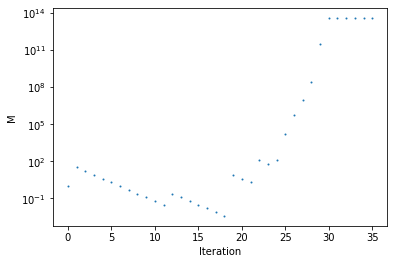

In [ ]:
plot_M(CN_trainer[1e-4])

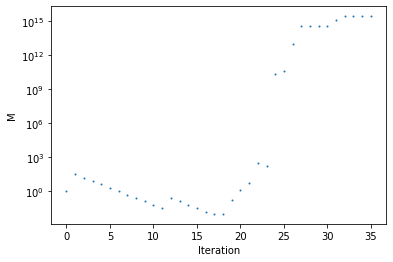

In [ ]:
plot_M(CN_trainer[1e-2])

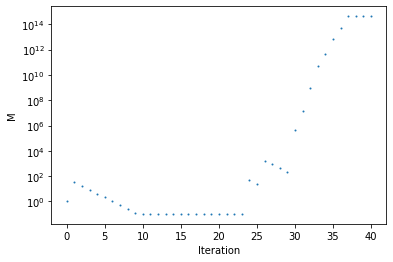

In [ ]:
plot_M(CN_trainer[1e-1])

min eigenvalue of (H + Mr/2*I) over all observed iterations:  0.00184122


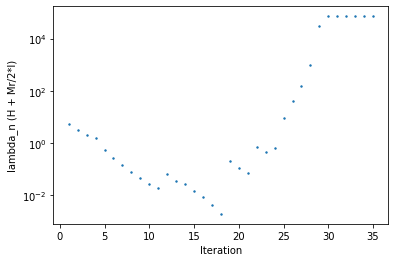

In [ ]:
plot_psd_ness(CN_trainer[1e-4])

min eigenvalue of (H + Mr/2*I) over all observed iterations: -0.00005757


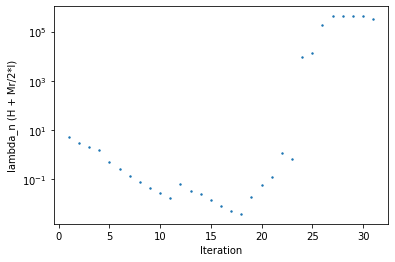

In [ ]:
plot_psd_ness(CN_trainer[1e-2])

In [ ]:
print_negative_psdness(CN_trainer[1e-2])

iter = 32: lambda_n = -5.757461258326657e-05, M = 2882303761517117.5, r = 0.0, lambda_n + M*r/2 = -5.757461258326657e-05
iter = 33: lambda_n = -5.757461258326657e-05, M = 2882303761517117.5, r = 0.0, lambda_n + M*r/2 = -5.757461258326657e-05
iter = 34: lambda_n = -5.757461258326657e-05, M = 2882303761517117.5, r = 0.0, lambda_n + M*r/2 = -5.757461258326657e-05
iter = 35: lambda_n = -5.757461258326657e-05, M = 2882303761517117.5, r = 0.0, lambda_n + M*r/2 = -5.757461258326657e-05


min eigenvalue of (H + Mr/2*I) over all observed iterations:  0.01663879


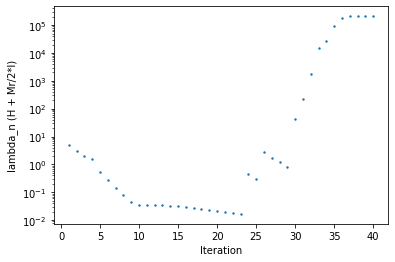

In [ ]:
plot_psd_ness(CN_trainer[1e-1])

In [1]:
#visualize_spectrum_evolution(CN_trainer[1e-4], plot_every_iter=1, bin_size=0.1, y_range=(0, 50))

In [2]:
#visualize_spectrum_evolution(CN_trainer[1e-2], plot_every_iter=1, bin_size=0.1, y_range=(0, 50))

In [3]:
#visualize_spectrum_evolution(CN_trainer[1e-1], plot_every_iter=1, bin_size=0.1, y_range=(0, 50))

In [4]:
#visualize_hessians_evolution(CN_trainer[1e-4], plot_every_iter=1)

In [5]:
#visualize_hessians_evolution(CN_trainer[1e-2], plot_every_iter=1)

In [6]:
#visualize_hessians_evolution(CN_trainer[1e-1], plot_every_iter=1)

# plot (Cubic Newton versions)

In [ ]:
metrics = [get_metrics(CN_trainer[1e-4]), get_metrics(CN_trainer[1e-2]), get_metrics(CN_trainer[1e-1])]
hessian_metrics = [get_hessian_metrics(CN_trainer[1e-4]), get_hessian_metrics(CN_trainer[1e-2]), get_hessian_metrics(CN_trainer[1e-1])]
labels = ["M_min=1e-4", "M_min=1e-2", "M_min=1e-1"]

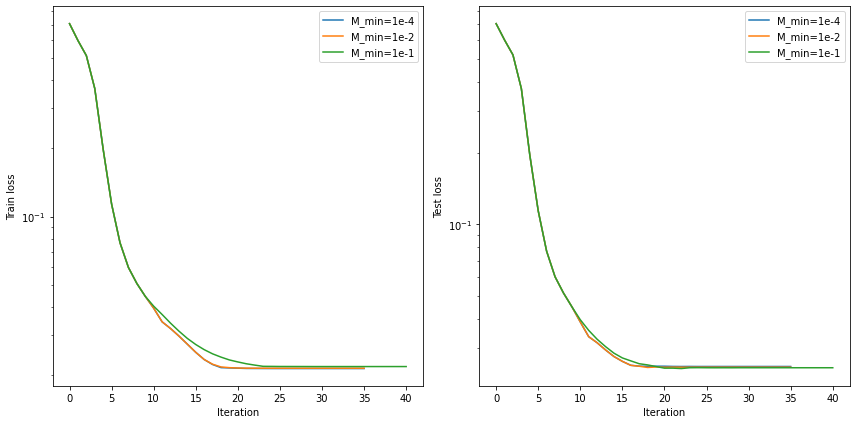

In [ ]:
plot_losses(metrics, labels)

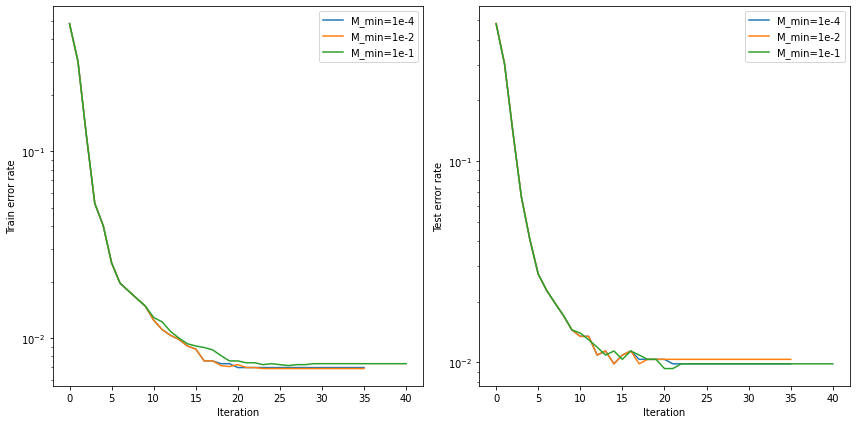

In [ ]:
plot_errors(metrics, labels)

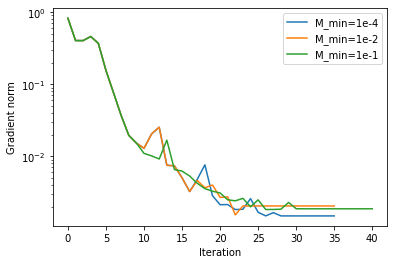

In [ ]:
plot_grad_norms(metrics, labels)

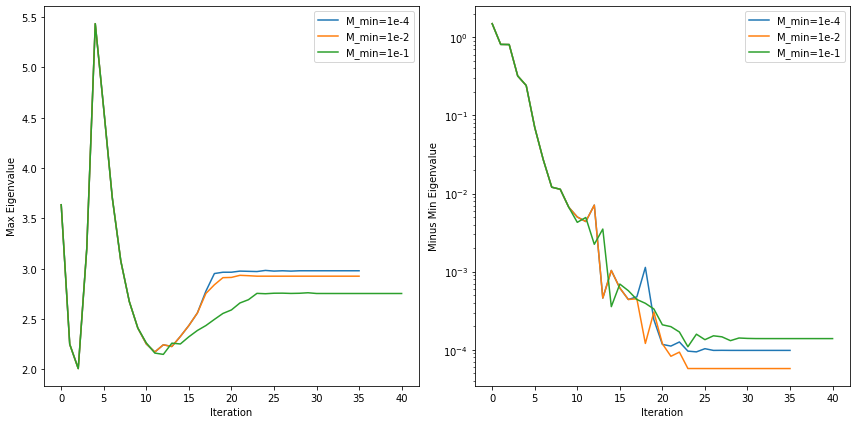

In [ ]:
plot_max_min_eigvals(hessian_metrics, labels)

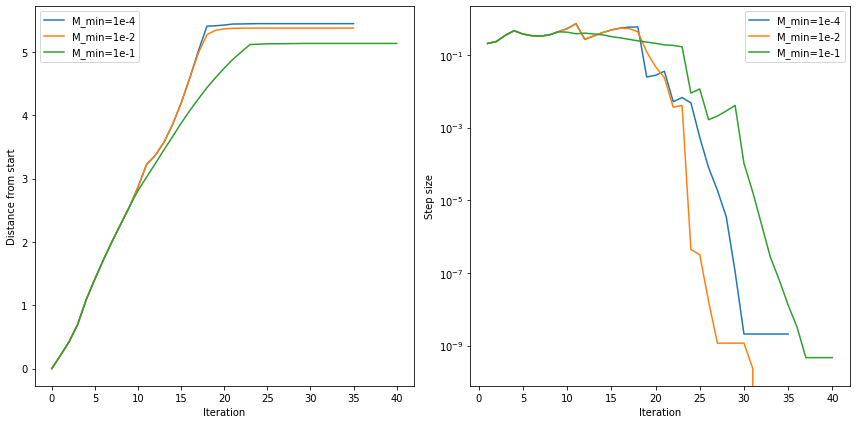

In [ ]:
plot_distances(metrics, labels)

# Gradient Descent

In [ ]:
seed = 0
max_iters = 1200
print_every = 100
eval_every = 10
eval_hessian_every = 50
save_spectrum_every = 200
save_hessian_every = 400
save_every = 1200
weight_decay = 0.
# kwargs
L = 1.0
L_min = 1e-3

model_dir = os.path.join(os.path.join(RESULTS_PATH, "GD"), f"seed={seed} L_min={L_min}")
print(f"model_dir: {model_dir}")

torch.manual_seed(seed)
GD_trainer = AdaptiveGDTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, L, L_min)
GD_trainer.load()
print_training_stats(GD_trainer, print_every)
#_ = GD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/layers=2 relu classes=[6,8]/GD/seed=0 L_min=0.001
     0: train loss =  0.706261, test loss =  0.704212, L =   1.00000000, time =    0.00 sec, lambda_n = -1.491387
   100: train loss =  0.044231, test loss =  0.044405, L =   1.00000000, time =    0.42 sec, lambda_n = -0.007384
   200: train loss =  0.036043, test loss =  0.033722, L =   0.50000000, time =    0.83 sec, lambda_n = -0.006617
   300: train loss =  0.029809, test loss =  0.028550, L =   0.50000000, time =    1.24 sec, lambda_n = -0.001464
   400: train loss =  0.026260, test loss =  0.026577, L =   1.00000000, time =    1.63 sec, lambda_n = -0.000830
   500: train loss =  0.024274, test loss =  0.025486, L =   1.00000000, time =    2.03 sec, lambda_n = -0.000471
   600: train loss =  0.023242, test loss =  0.024994, L =   0.50000000, time =    2.44 sec, lambda_n = -0.000640
   700: train loss =  0.022671, test loss =  0.024774, L =   1.00000000, time =    2.85 sec, lam

In [ ]:
print_test_accuracy(GD_trainer)

Best test accuracy: 99.17%
Last test accuracy: 99.17%


In [7]:
#visualize_spectrum_evolution(GD_trainer, y_range=(0, 50), bin_size=0.1)

In [8]:
#visualize_hessians_evolution(GD_trainer)

# SGD

In [ ]:
seed = 0
max_iters = 1200
print_every = 100
eval_every = 10
eval_hessian_every = 50
save_spectrum_every = 200
save_hessian_every = 400
save_every = max_iters
weight_decay = 0.
# kwargs
optim_class = torch.optim.SGD
optim_params = {'lr': 0.1}
dataset = get_dataset()
batch_size = 64

model_dir = os.path.join(os.path.join(RESULTS_PATH, "SGD"), f"seed={seed} lr={optim_params['lr']}, batch_size={batch_size}")
print(f"model_dir: {model_dir}")

torch.manual_seed(seed)
SGD_trainer = CustomTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, optim_class, optim_params, batch_size)
SGD_trainer.load()
print_training_stats(SGD_trainer, print_every)
#_ = SGD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/layers=2 relu classes=[6,8]/SGD/seed=0 lr=0.1, batch_size=64
     0: train loss =  0.706261, test loss =  0.704212, time =    0.00 sec, lambda_n = -1.491387
   100: train loss =  0.072616, test loss =  0.070625, time =    0.08 sec, lambda_n = -0.083678
   200: train loss =  0.058977, test loss =  0.059773, time =    0.17 sec, lambda_n = -0.017544
   300: train loss =  0.055561, test loss =  0.057687, time =    0.25 sec, lambda_n = -0.026079
   400: train loss =  0.052914, test loss =  0.053750, time =    0.33 sec, lambda_n = -0.023530
   500: train loss =  0.050632, test loss =  0.052331, time =    0.41 sec, lambda_n = -0.013533
   600: train loss =  0.048830, test loss =  0.049887, time =    0.48 sec, lambda_n = -0.013091
   700: train loss =  0.049314, test loss =  0.053035, time =    0.57 sec, lambda_n = -0.038860
   800: train loss =  0.046014, test loss =  0.047642, time =    0.64 sec, lambda_n = -0.008088
   900: train loss 

In [ ]:
print_test_accuracy(SGD_trainer)

Best test accuracy: 98.71%
Last test accuracy: 98.55%


In [9]:
#visualize_spectrum_evolution(SGD_trainer, y_range=(0,50), bin_size=0.1)

In [10]:
#visualize_hessians_evolution(SGD_trainer)

# Plots

In [ ]:
metrics = [get_metrics(CN_trainer[1e-1]), get_metrics(GD_trainer), get_metrics(SGD_trainer)]
hessian_metrics = [get_hessian_metrics(CN_trainer[1e-1]), get_hessian_metrics(GD_trainer), get_hessian_metrics(SGD_trainer)]
labels = ["CN", "GD", "SGD"]

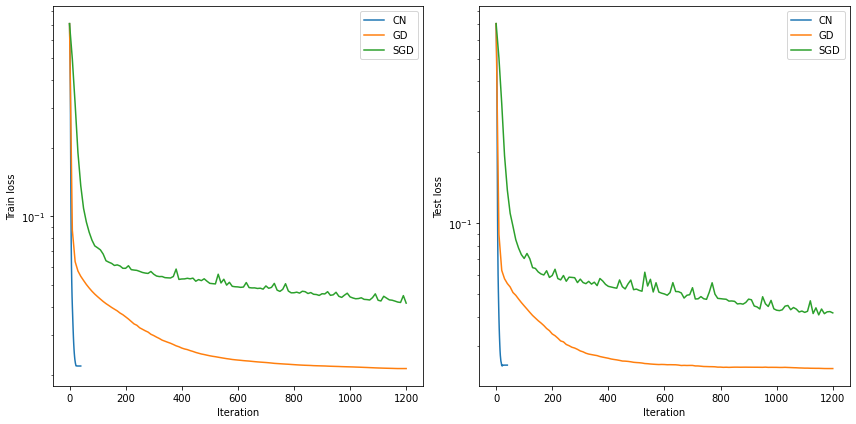

In [ ]:
plot_losses(metrics, labels)

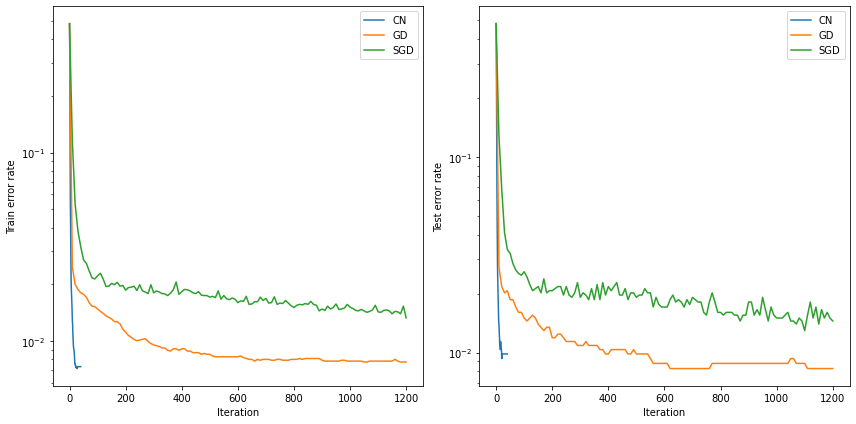

In [ ]:
plot_errors(metrics, labels)

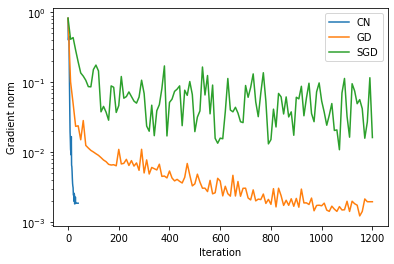

In [ ]:
plot_grad_norms(metrics, labels)

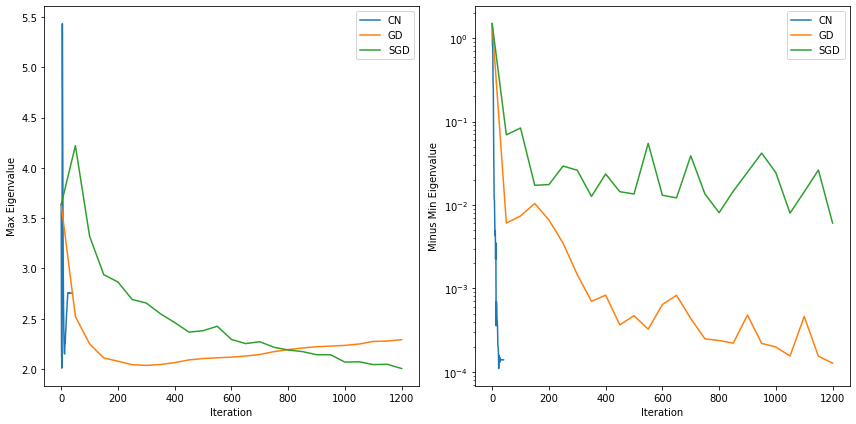

In [ ]:
plot_max_min_eigvals(hessian_metrics, labels)

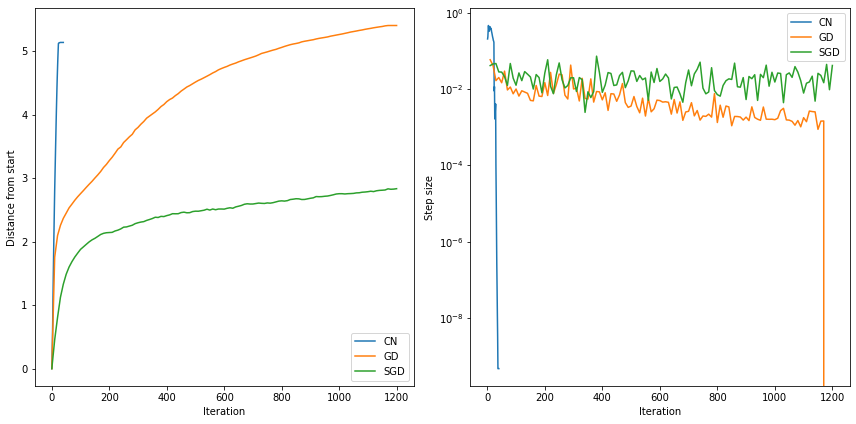

In [ ]:
plot_distances(metrics, labels)